In [1]:
#Imports and everything else, better to not modify this part
import numpy as np
import sys
import pandas as pd
import math
#
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
# from collections import namedtuple

try:
    # for Python2
    from Tkinter import *   ## notice capitalized T in Tkinter 
except ImportError:
    # for Python3
    from tkinter import *   ## notice lowercase 't' in tkinter here
    
    
    pd.set_option('display.max_rows', 100)


In [2]:
#Import gossip log and filter the messages received on grpc

fileHandle = open('/home/flav/gossip/gossip_data/data/lotus/general/log_stdout.out', "r", encoding="latin1")
lines = fileHandle.readlines()

with open('/home/flav/gossip/gossip_data/filter/general.out', 'w+') as f:
    for line in lines:
      if '| gRPC-Server | received |' in line:
        print(line, file=f)
fileHandle.close()

In [3]:
# Create dataset for the gossip and correct the datetime
data = pd.read_csv('/home/flav/gossip/gossip_data/filter/general.out', sep="|", header=None, error_bad_lines=False, warn_bad_lines=False, usecols=[0,6,7])
df = pd.DataFrame(data)

#Rename
df = df.rename(index=str, columns={0: "DateTime", 7: "ValidatorKey", 6: "Hash"})
# df.style

# Limit time, because the others ran for only a couple of hours
# # print(df.loc["DateTime" == "21397072576816640211201_195113"])
# # df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce', format="%Y%m%d_%H%M%S")
# df = df.loc[df["DateTime"] > "2022/04/11 01:00:00"]
# df = df.loc[df["DateTime"] < "2022/04/11 03:00:00"]
# df = df[df["DateTime"].isin(pd.date_range("2021-12-01 19:25:00", "2021-12-01 20:28:00"))]

df.head(5)

,DateTime,Hash,ValidatorKey
0,2022-06-09_21:57:40.349,27ddaaf0bd627adf176941cdc820cefc6f44292273390...,n9M2m9ScciFZ4QT2sjbsZ9Z1VW1WotamotvGBLw8M286o...
1,2022-06-09_21:57:52.250,56c3103014f32e4c03abec7410b100ded4b61754f118d...,n9M2m9ScciFZ4QT2sjbsZ9Z1VW1WotamotvGBLw8M286o...
2,2022-06-09_21:57:52.309,d55f7c6d59e311724c15f50d04789e658ad7f9f8ad7e7...,n944bhsNXNr3VWAs24Nvf9zhxrDR9AzAmspmhJbhu9oor...
3,2022-06-09_21:57:52.483,57181a4bbbe0b744f3869ca28c23052de55a734300303...,n94HshsgAWC6nEuqZsRrD19SUvDjqe4fKhVCJmKwe5kuv...
4,2022-06-09_21:57:52.901,f329e28260f9fc9c2ec622ae46f42112cb6adfb3033c5...,n9LtVzsqTa7dAv4UJSKbrr1RdFQDLx8iCgcDxthEpdX9U...


In [4]:
#Aggregate by hash and count
# dfQuantile1 = df.groupby(['grp', 'metric', 'method', 'region', 'selectivity']).quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear').reset_index()
# dfQuantile1 = dfQuantile1.rename(index=str, columns={"value": "first"})

dups = df.drop(columns=["DateTime","ValidatorKey"])
dups = dups.groupby(dups.columns.tolist()).size().reset_index().rename(columns={0:'dups'}).sort_values(by=["dups"], ascending=False)

dups.head(5)
dupsSave=dups.loc[dups["dups"] < 25]
dupsSave.to_csv('/home/flav/gossip/gossip_data/dupsGeneral.csv')

In [5]:
hashLoc = dups.loc[dups['dups'] == 4]['Hash'].values[0]
mostDups = df.loc[df['Hash'] == hashLoc]

mostDups.head(5)
# mostDups.style
#868cd166b1a4c1dd879bb5f0a2d1c1de213d9b3eafe95
#3986ab419e31f171abae9d5ca2fcfda199bfef896362e

,DateTime,Hash,ValidatorKey
13995,2022-06-09_22:29:16.175,714e6d88c0d6f5c79756afcfa54395abb18220a3634bf...,n9Jt1kRnDK6NeUjvYhzGTVR6as8edQBgs9XQASu4dp8Zy...
14455,2022-06-09_22:30:16.341,714e6d88c0d6f5c79756afcfa54395abb18220a3634bf...,n9Jt1kRnDK6NeUjvYhzGTVR6as8edQBgs9XQASu4dp8Zy...
14570,2022-06-09_22:30:31.373,714e6d88c0d6f5c79756afcfa54395abb18220a3634bf...,n9Jt1kRnDK6NeUjvYhzGTVR6as8edQBgs9XQASu4dp8Zy...
14898,2022-06-09_22:31:16.495,714e6d88c0d6f5c79756afcfa54395abb18220a3634bf...,n9Jt1kRnDK6NeUjvYhzGTVR6as8edQBgs9XQASu4dp8Zy...


In [6]:
#The number of messages sent x times
dist = dups.drop(columns=["Hash"])

dist = dist.groupby(dist.columns.tolist()).size().reset_index().rename(columns={0:'distribution'}).sort_values(by=["distribution"], ascending=False)

dist.head(5)

,dups,distribution
0,1,2197
1,2,887
2,3,582
3,4,383
4,5,273


In [7]:
#Percentage of duplicates
# dist2 = dist[loc[dups]]
totalMessages = dist["distribution"].sum()
perc = dist

perc["percentage"] = (perc["distribution"]*100)/totalMessages
perc = perc.sort_values(by="distribution", ascending=False)

#Remove outliers... everyone that is lower than 0.014%
percHist = perc.loc[perc["dups"] < 25].drop(columns=["distribution"])
# percHist.to_csv('/home/flav/gossip/gossip_data/dupsGeneral.csv')
percHist.head(100)

,dups,percentage
0,1,37.918536
1,2,15.308940
2,3,10.044874
3,4,6.610287
4,5,4.711771
5,6,3.710735
6,7,3.227477
7,8,2.795996
8,9,1.863997
9,10,1.536072


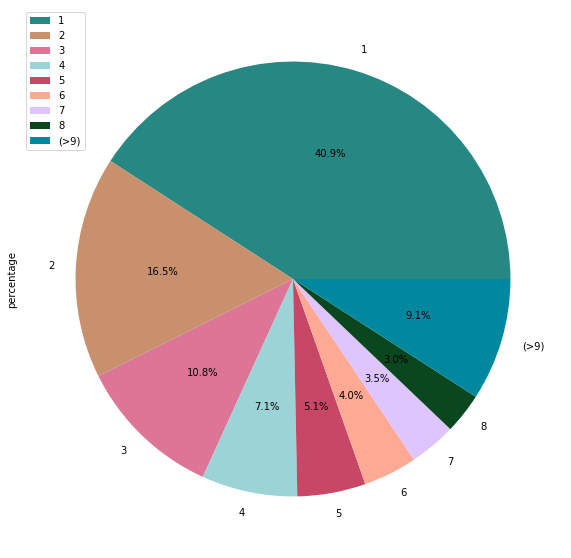

In [8]:
#Plot percentage

#If the percenatge is under 1%, put on the category "other"
percPlot = perc.loc[perc["percentage"] > 2].drop(columns=["distribution"])

# % under 1%
percOther = perc["percentage"].loc[perc["percentage"] <= 1].sum()
# generate row to append
percOtherRow = pd.DataFrame([["(>9)", percOther]], columns=["dups", "percentage"])

percPlot=percPlot.append(percOtherRow, ignore_index=True)
# percPlot = percPlot.reindex(percPlot["dups"])

#set colors, cause they are repeting when on automatic
colors = ['#278782', '#c9906d', '#DD7596', '#9cd3d6', '#c74767', '#fea993', '#dfc5fe', '#0a461e', '#01889f', '#2bb179', '#B7C3F3', 'pink'] 

percPlot.style
percPlotPie = percPlot.plot(kind="pie", y="percentage", figsize=(10,10), autopct="%1.1f%%", labels=percPlot["dups"], colors=colors)

fig = percPlotPie.get_figure()
# fig.savefig("percentageDupsGeneral.png")

In [9]:
sumMessages = dups['dups'].sum()

print(sumMessages)


28195


[Text(0, 0.5, 'Frequency'), Text(0.5, 1.0, 'Frequency Histogram')]

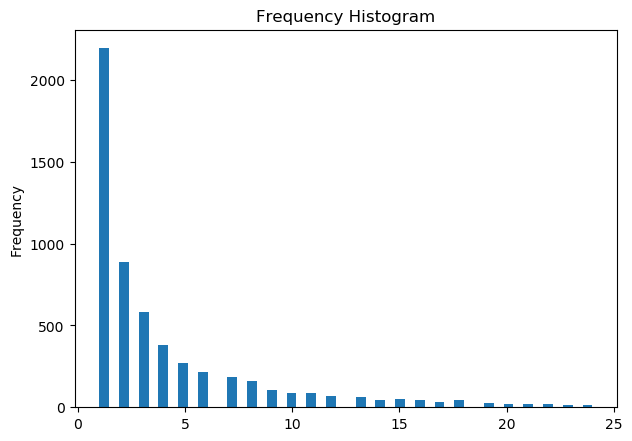

In [10]:
#Histogram
hist = dups['dups'].loc[dups['dups'] < 25]
# dupsNorm.head(5)

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.hist(hist, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency')